# 图像过滤器

过滤器实际上是一种核卷积, 它作用在图像上可以实现对图像中某种特定信号的过滤. 通过过滤器, 我们可以实现图像的边缘或某种特定形状的检测.


过滤器大体可以分为高通和低通过滤器:

- 高通过滤器一般过滤图像中颜色变化明显的地方, 可用于边缘检测.
- 低通滤波器过滤图像中颜色固定的地方, 去除噪声, 使图像更加平滑.


In [10]:
import utils

import matplotlib.pyplot as plt

import numpy as np

import cv2

%matplotlib inline

## 索贝尔过滤器

索贝尔过滤器是一种简单的高通滤波器, 它的卷积核有如下两种形式:

$$
S_x=\left(
    \begin{matrix}
        -1 & 0 & 1\\
        -2 & 0 & 2\\
        -1 & 0 & 1
    \end{matrix}
\right),
S_y=\left(
    \begin{matrix}
        -1 & -2 & -1\\
        0 & 0 & 0\\
        1 & 2 & 1
    \end{matrix}
\right)
$$

其中, $S_x$用于检测垂直边界, $S_y$用于检测水平边界.

Sobel过滤器不仅可以检测到边界, 它还能反应边界的强度. 如果卷积运算求得的值越大, 则边界越强.

下面我们用一个具体的例子来感受Sobel过滤器.


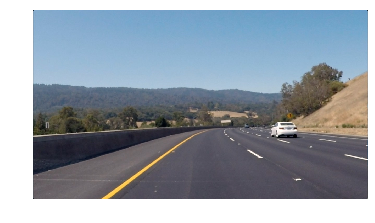

In [6]:
image = utils.imread('images/curved_lane.jpg')
plt.axis('off')
plt.imshow(image)

这是一张道路的图像, 我们可以看到其中有很多明显的边缘, 例如交通线是垂直边缘, 远处的山峦是水平边缘.

因为不关心图像的具体颜色, 所以将图像转换为灰度图.

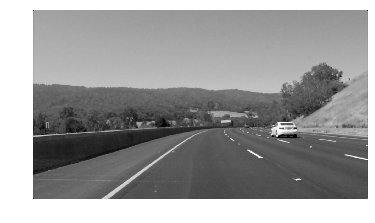

In [8]:
gray = utils.rgb2gray(image)

plt.axis('off')
plt.imshow(gray, cmap='gray')

下面使用Sobel过滤器对图像进行处理.

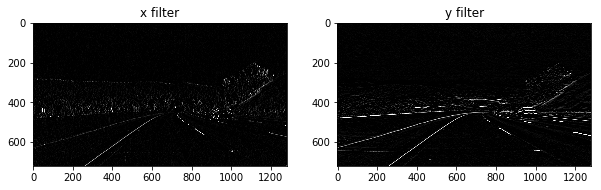

In [11]:
sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])
sobel_y = np.array([[-1, -2, -1],
                    [0, 0, 0],
                    [1, 2, 1]])

x_filtered_image = cv2.filter2D(gray, -1, sobel_x)
y_filtered_image = cv2.filter2D(gray, -1, sobel_y)

utils.show_images_in_single_row([x_filtered_image, y_filtered_image], ['x filter', 'y filter'], ['gray', 'gray'])

上图中我们可以观察到很多噪声. 高通滤波器对这些噪声没有处理能力, 在图像中反应出来就是零散的噪声点.

## 高斯模糊

高斯模糊是一种低通滤波器, 可以在保留边缘的同时过滤掉图像中的一些噪声点.

高斯模糊的卷积核是下面这样的:

$$
G=\frac{1}{16}\times\left(
    \begin{matrix}
        1 & 2 & 1\\
        2 & 4 & 2\\
        1 & 2 & 1
    \end{matrix}
\right)
$$

这个卷积核可以将图像中变化不明显的一些区域归一化.乘以$\frac{1}{16}$是为了让卷积核归一化.

一般在进行边缘检测之前, 都要对图像进行高斯模糊处理, 使得检测的结果包含的噪声更少.

下面以一张大脑的医学图像为例:

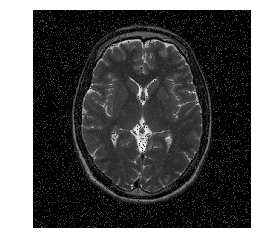

In [14]:
image = utils.imread('images/noisy_brain_MR.jpg')

plt.axis('off')
plt.imshow(image)

这张图像包含了很多噪声点, 下面对其做高斯模糊处理.

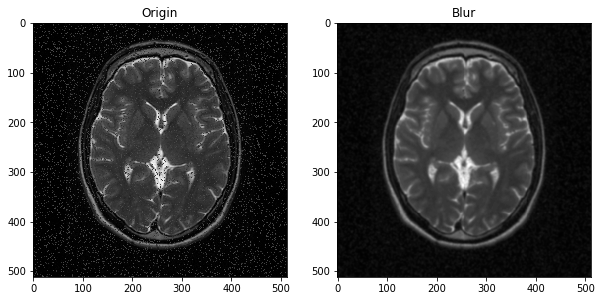

In [15]:
gray = utils.rgb2gray(image)
gray_blur = cv2.GaussianBlur(gray, (9, 9), 0)

utils.show_images_in_single_row([gray, gray_blur], ['Origin', 'Blur'], ['gray', 'gray'])

可以看到旁边的噪声点明显变少了. 随后再对其做索贝尔过滤.

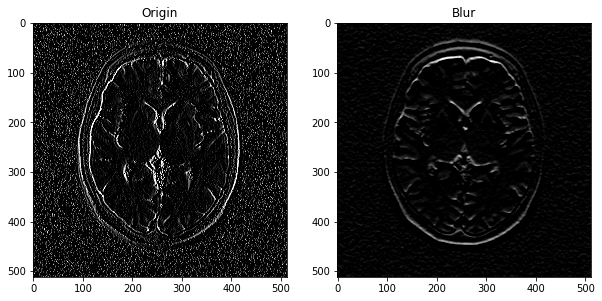

In [16]:
sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])

filtered_image = cv2.filter2D(gray, -1, sobel_x)
blur_filtered_image = cv2.filter2D(gray_blur, -1, sobel_y)

utils.show_images_in_single_row([filtered_image, blur_filtered_image], ['Origin', 'Blur'], ['gray', 'gray'])

经过高斯模糊的图像再做边缘检测, 结果中的噪声要少得多. 所以一般我们在做边缘检测前, 都会对图像做高斯模糊处理.

## Canny 边缘检测

Canny边缘检测是一种常用的边缘检测过滤器. 它对一张图像依次做如下处理:

- 使用高斯模糊过滤掉噪声
- 使用Sobel过滤器确定图像边缘的强度和方向
- 使用非极大抑制(non-maximum suppression)来观察每个检测边缘的强度和方向, 选出局部最大像素. 把最强的边缘绘制成连续, 一个像素宽的细线.
- 使用滞后阈值(hysteresis threshold)来分离最佳边缘.

滞后阈值需要设定高阈值和低阈值, 高于高阈值的强边缘会被保留, 低于低阈值的弱边缘会被舍弃.

位于高阈值和低阈值之间的边缘, 只有当期和另一个强边缘相连时, 才会被保留. 使用滞后阈值可以消除部分弱边缘.

下面来看一个简单的示例, 图片是一张向日葵的图片.

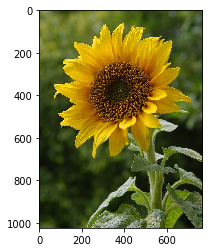

In [17]:
flower = utils.imread('images/sunflower.jpg')

plt.imshow(flower)

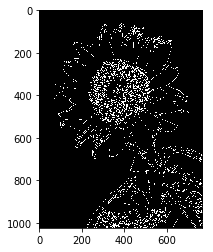

In [26]:
gray = utils.rgb2gray(flower)

# Canny边缘检测的阈值.
# 这两个参数会控制过滤器对边缘的敏感程度.
lower = 100
upper = 200

edges = cv2.Canny(gray, lower, upper)

plt.imshow(edges, cmap='gray')